<h1>Data Analysis and Visualization Home Assignment</h1>
<li>I've tried to outline the steps for you so please make use of the cells
<li>If you run into data size issues, subset your data. But try to use as much as you can get away with
<li>Note that many of the steps will take a while to run, especially if your computer is not powerful enough. Be patient! 


<ol>
<li>Read the data from <a href="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv">https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv</a>
<li>Remove any data that is outside the NYC bounding box
<ul>
<li>NYC bounding box: westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
<li>See http://boundingbox.klokantech.com for info on bounding boxes
</ul>
<li>Calculate taxi trip duration and save in a new column "duration"
<li>Convert duration into a float
<li>Do some basic analysis (see below)
<li>Add a day of week column
<li>Add an hour of day column
<li>Do some analysis (see below)
<li>Divide the data into zones
<ul>
<li>write a function createZoneTable(zone_factor) that divides the bounding box into zones
<li>the idea is to create zone_factor * zone_factor zones
<li>e.g., if zone_factor is 20, you'll create 20*20 = 400 zones
<li>Divide the longitude (-73.7526 to -74.2635) into zone_factor (e.g., 20) sections
<li>Divide the latitude (40.4856 to 40.9596) into zone_factor (e.g., 20) sections
<li>Return a table (a list of lists) containing a zone id, and the coordinates of the zone
<li>(see e.g., below)
</ul>
<li>Write a function get_zone(lat,lon) that figures out the zone given a latitude and longitude
<li>Apply this function to the dataframe, first with pickup lats and longs; then with dropoff lats and longs
<li>This will give two new "pickup_zone" and "dropoff_zone" columns
<li>Do some analysis (see below)
<li>Using folium, draw a heatmap of the number of trips originating in each zone
<ul>
<li>Create a geojson object for all the zones 
<li>Create a df that contains zone numbers and the number of trips originating in each zone
<li>Use folium to create a heatmap
<li><b>OPTIONAL:</b> You'll notice that the bounding box is much larger than New York City. Try to remove every zone that has 0 originating trips from your map. (Hint: You can remove them from the geojson object)


<h2>Read the data</h2>


In [1]:
#Add necessary imports and functions to read the data
import pandas as pd
#url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv'
#df = pd.read_csv(url)

In [2]:
#df.to_csv('data.csv')

In [3]:
#Should be faster than downloading
df = pd.read_csv('yellow_tripdata_small_2016-01.csv')

In [4]:
df_copy = df.copy()

<h2>Remove data outside the bounding box</h2>


In [5]:
westlimit=-74.2635; southlimit=40.4856; eastlimit=-73.7526; northlimit=40.9596
#Remove the data that is not within the limits specified above

df = df[df.pickup_latitude.between(southlimit,northlimit) & df.pickup_longitude.between(westlimit, eastlimit)]
#& df.pickup_latitude.between(westlimit,eastlimit)]'''

In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-01-25 10:44:43,2016-01-25 10:55:40,1,1.00,-73.980652,40.765316,1,N,-73.989792,40.752026,1,8.5,0.0,0.5,1.85,0.0,0.3,11.15
1,1,2016-01-13 10:19:36,2016-01-13 10:25:41,1,0.80,-73.948990,40.777428,1,N,-73.959045,40.771893,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16
2,2,2016-01-12 00:42:42,2016-01-12 00:51:04,1,2.17,-74.008377,40.735664,1,N,-74.013580,40.707985,1,9.0,0.5,0.5,2.00,0.0,0.3,12.30
3,1,2016-01-10 16:21:17,2016-01-10 16:24:31,1,0.70,-73.961266,40.772495,1,N,-73.955887,40.779671,1,4.5,0.0,0.5,1.30,0.0,0.3,6.60
4,2,2016-01-05 11:29:53,2016-01-05 11:52:24,5,0.78,-73.976532,40.764683,1,N,-73.966904,40.769787,2,13.5,0.0,0.5,0.00,0.0,0.3,14.30


<h2>Add a column for taxi trip duration</h2>
<li>strptime formats: http://pubs.opengroup.org/onlinepubs/009695399/functions/strptime.html

In [7]:
import datetime as dt
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

date_format = '%Y-%m-%d %H:%M:%S'
df.tpep_dropoff_datetime = df.tpep_dropoff_datetime.progress_apply(lambda x: datetime.strptime(x, date_format))
df.tpep_pickup_datetime = df.tpep_pickup_datetime.progress_apply(lambda x: datetime.strptime(x, date_format))

100%|██████████| 1073378/1073378 [00:16<00:00, 66407.50it/s]


In [8]:
df['trip_duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

<h2>Convert duration column into a float (number of seconds)</h2>
<li><span style="color:blue">timedelta64(1, 's')</span> represents one second

In [9]:
df['duration'] = df.trip_duration.apply(lambda x: x.total_seconds())

In [10]:
df_copy = df.copy()

<h2>Remove data where duration is greater than 10000 seconds</h2>

In [11]:
df = df[df['duration'] < 10000]

<h2>Plot duration and compare with a gamma distribution</h2>

In [12]:
!pip install --upgrade seaborn
!pip install --upgrade statsmodels

Requirement already up-to-date: seaborn in /Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages (0.9.0)
Requirement already up-to-date: statsmodels in /Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages (0.10.1)


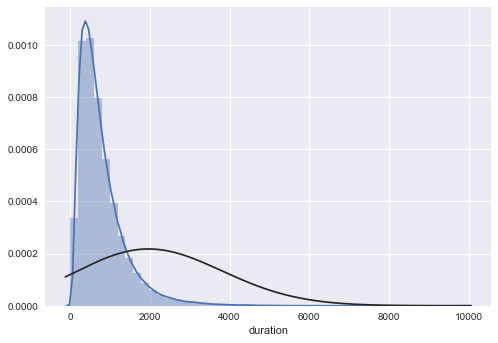

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from scipy import stats

df = df[df['trip_distance'] < 4e4]
sns.distplot(df['duration'], kde=True, fit=stats.gamma)


<h2>Plot the scatter plot between trip_distance and duration</h2>

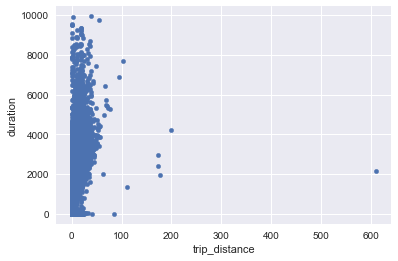

In [14]:
df.plot.scatter('trip_distance', 'duration')

<h2>Create a column "day_of_week" that puts in an integer for the weekday</h2>
<li>Monday = 1, Sunday = 7
<li>Investigate here! https://docs.python.org/3/library/datetime.html
<li>Use tpep_pickup_datetime to get the weekday

In [15]:
df['day_of_week'] = df['tpep_pickup_datetime'].apply(lambda x: x.isoweekday())

<h2>Create time of day buckets using the hour part of tpep_pickup_datetime</h2>

In [16]:
df['pickup_hour'] = df['tpep_pickup_datetime'].apply(lambda x: x.hour)

<h2>Plot a bar graph that groups the data by day of week and then by time of day</h2>
<li>Do you notice any differences?</li>

In [17]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_duration', 'duration',
       'day_of_week', 'pickup_hour'],
      dtype='object')

In [18]:
wk_group = df.groupby('day_of_week').mean()['total_amount']
tm_group = df.groupby('pickup_hour').mean()['total_amount']

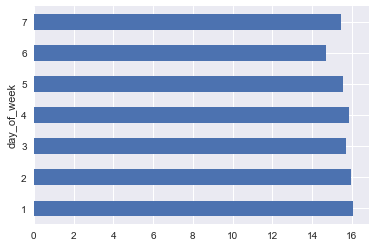

In [19]:
wk_group.plot(kind='barh')

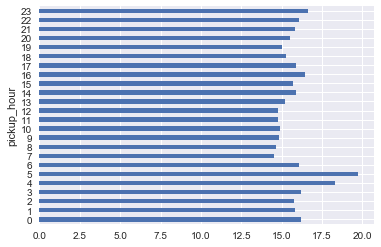

In [20]:
tm_group.plot(kind='barh')

<h2>Create zones</h2>

In [21]:
import numpy as np
import itertools as it

def createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596):
    zone_table = list()
    #Your code goes here

    lat_steps = np.linspace(southlimit, northlimit, zone_factor+1)
    lat_chunks = [(value,lat_steps[i+1]) for i,value in enumerate(lat_steps) if i<len(lat_steps)-1]

    lon_steps = np.linspace(westlimit, eastlimit, zone_factor+1)
    lon_chunks = [(value, lon_steps[i+1]) for i, value in enumerate(lon_steps) if i<len(lon_steps)-1]

    zone_table = []
    #counter = 0
    for i, lat in enumerate(lat_chunks):
        for j, lon in enumerate(lon_chunks):
            zone_coords = [list(v) for v in it.product(lon, lat)]
            zone_coords = [zone_coords[0], zone_coords[1],zone_coords[3],zone_coords[2],zone_coords[0]]
            #name = f'{counter}'
            name = f'{j}_{i}'
            zone_table.append((name, zone_coords))
            #counter += 1


    return zone_table

Example of a zone table

[('00',
  [[40.4856, -74.2635],
   [40.4856, -74.21240999999999],
   [40.533, -74.21240999999999],
   [40.533, -74.2635],
   [40.4856, -74.2635]]),
 ('01',
  [[40.4856, -74.21240999999999],
   [40.4856, -74.16131999999999],
   [40.533, -74.16131999999999],
   [40.533, -74.21240999999999],
   [40.4856, -74.21240999999999]]),
 ('02',
  [[40.4856, -74.16131999999999],
   [40.4856, -74.11022999999999],
   [40.533, -74.11022999999999],
   [40.533, -74.16131999999999],
   [40.4856, -74.16131999999999]]),
 ('03',
  [[40.4856, -74.11022999999999],
   [40.4856, -74.05913999999999],
   [40.533, -74.05913999999999],
   [40.533, -74.11022999999999],
   [40.4856, -74.11022999999999]]),

In [22]:
def createGeoJsonObject(zone_table):
    zone_data_dict = dict()
    zone_data_dict['type'] = 'FeatureCollection'
    zone_data_dict_features = list()
    zone_data_dict['features'] = zone_data_dict_features
    
    #Your code goes here
    
    #Create geometry object:
    for name, coords in zone_table:
        feature = {
                    'type': 'Feature',

                    'geometry': {
                                'type':'Polygon',
                                'coordinates': [coords]
                                },
                    'properties': {
                                'name': name
                                }
                    }

        zone_data_dict['features'].append(feature)
        
    return zone_data_dict

In [23]:
createZoneTable(5)

[('0_0',
  [[-74.2635, 40.4856],
   [-74.2635, 40.5804],
   [-74.16131999999999, 40.5804],
   [-74.16131999999999, 40.4856],
   [-74.2635, 40.4856]]),
 ('1_0',
  [[-74.16131999999999, 40.4856],
   [-74.16131999999999, 40.5804],
   [-74.05914, 40.5804],
   [-74.05914, 40.4856],
   [-74.16131999999999, 40.4856]]),
 ('2_0',
  [[-74.05914, 40.4856],
   [-74.05914, 40.5804],
   [-73.95696, 40.5804],
   [-73.95696, 40.4856],
   [-74.05914, 40.4856]]),
 ('3_0',
  [[-73.95696, 40.4856],
   [-73.95696, 40.5804],
   [-73.85478, 40.5804],
   [-73.85478, 40.4856],
   [-73.95696, 40.4856]]),
 ('4_0',
  [[-73.85478, 40.4856],
   [-73.85478, 40.5804],
   [-73.7526, 40.5804],
   [-73.7526, 40.4856],
   [-73.85478, 40.4856]]),
 ('0_1',
  [[-74.2635, 40.5804],
   [-74.2635, 40.6752],
   [-74.16131999999999, 40.6752],
   [-74.16131999999999, 40.5804],
   [-74.2635, 40.5804]]),
 ('1_1',
  [[-74.16131999999999, 40.5804],
   [-74.16131999999999, 40.6752],
   [-74.05914, 40.6752],
   [-74.05914, 40.5804],
  

In [24]:
coords = createZoneTable(5)

import geojsonio
import json
geojsonio.display(json.dumps(createGeoJsonObject(coords)))

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-74.2635%2C%2040.4856%5D%2C%20%5B-74.2635%2C%2040.5804%5D%2C%20%5B-74.16131999999999%2C%2040.5804%5D%2C%20%5B-74.16131999999999%2C%2040.4856%5D%2C%20%5B-74.2635%2C%2040.4856%5D%5D%5D%7D%2C%20%22properties%22%3A%20%7B%22name%22%3A%20%220_0%22%7D%7D%2C%20%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-74.16131999999999%2C%2040.4856%5D%2C%20%5B-74.16131999999999%2C%2040.5804%5D%2C%20%5B-74.05914%2C%2040.5804%5D%2C%20%5B-74.05914%2C%2040.4856%5D%2C%20%5B-74.16131999999999%2C%2040.4856%5D%5D%5D%7D%2C%20%22properties%22%3A%20%7B%22name%22%3A%20%221_0%22%7D%7D%2C%20%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinat

Example of the 'features' list in the geojson object

{'features': [{'geometry': {'coordinates': [[[-74.2635, 40.4856],
      [-74.21240999999999, 40.4856],
      [-74.21240999999999, 40.533],
      [-74.2635, 40.533],
      [-74.2635, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '00'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[-74.21240999999999, 40.4856],
      [-74.16131999999999, 40.4856],
      [-74.16131999999999, 40.533],
      [-74.21240999999999, 40.533],
      [-74.21240999999999, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '01'},
   'type': 'Feature'},
  {'geometry': {'coordinates': [[[-74.16131999999999, 40.4856],
      [-74.11022999999999, 40.4856],
      [-74.11022999999999, 40.533],
      [-74.16131999999999, 40.533],
      [-74.16131999999999, 40.4856]]],
    'type': 'Polygon'},
   'properties': {'zone_id': '02'},
   'type': 'Feature'},

<h3>Create the zone table for zone_factor = 20</h3>

In [25]:
zone_factor = 20
zone_table = createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596)


In [26]:
geojsonio.display(json.dumps(createGeoJsonObject(zone_table)))

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-74.2635%2C%2040.4856%5D%2C%20%5B-74.2635%2C%2040.509299999999996%5D%2C%20%5B-74.237955%2C%2040.509299999999996%5D%2C%20%5B-74.237955%2C%2040.4856%5D%2C%20%5B-74.2635%2C%2040.4856%5D%5D%5D%7D%2C%20%22properties%22%3A%20%7B%22name%22%3A%20%220_0%22%7D%7D%2C%20%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B-74.237955%2C%2040.4856%5D%2C%20%5B-74.237955%2C%2040.509299999999996%5D%2C%20%5B-74.21240999999999%2C%2040.509299999999996%5D%2C%20%5B-74.21240999999999%2C%2040.4856%5D%2C%20%5B-74.237955%2C%2040.4856%5D%5D%5D%7D%2C%20%22properties%22%3A%20%7B%22name%22%3A%20%221_0%22%7D%7D%2C%20%7B%22type%22%3A%20%22Feature%22%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygo

<h2>Write a function that returns a zone number given a latitude and a longitude</h2>

<li>The function should return a string zone number
<li>For the example, <span style="color:blue">get_zone(40.65,-74.19, zone_table)</span> the function should return "31"

In [27]:
def get_zone(lon, lat, zone_table):
    west_limit, south_limit = zone_table[0][1][0]
    east_limit, north_limit = zone_table[-1][1][0]

    chunks_per_side = len(zone_table)**.5

    lon_d = (east_limit-west_limit)/chunks_per_side
    lat_d = (north_limit-south_limit)/chunks_per_side

    #lon = -74.19
    #lat = 40.65

    lon_zone = (lon-west_limit)//lon_d
    lat_zone = (lat-south_limit)//lat_d

    return f'{int(lon_zone)-1}_{int(lat_zone)-1}'



In [28]:
zone_dict = {i:j for i,j in zone_table}

In [29]:
lon = -74.19
lat = 40.65

k = get_zone(lon, lat, zone_table)
print(zone_dict[k])

[[-74.21240999999999, 40.6278], [-74.21240999999999, 40.6515], [-74.186865, 40.6515], [-74.186865, 40.6278], [-74.21240999999999, 40.6278]]


<h2>Create  pickup_zone and dropoff_zone columns for the dataframe</h2>
<li>This is a little tricky
<li>Pandas 'apply' function applies a function to each row in turn


<h4>apply</h4>

df.apply(foo)<br>
translates to<br>
foo(row1)<br>
foo(row2)<br>
foo(row3)<br>
i.e., the table row is the implicit argument of foo.
<p>
If we want to write our own foo, the argument to foo will be a dataframe row.<p>
From this row, we can extract the values we want and pass it to the explicit arguments of foo
<p>


In [30]:
import pandas as pd
df_sample = pd.DataFrame([[1,5,7],[2,4,6],[3,9,2]],columns=['A','B','C'])

print(df_sample)
def foo(x,y):
    return x+y

df_sample['new_col'] = df_sample.apply(lambda x: foo(x['A'],x['B']),axis=1)
#axis = 1 means extract data from rows of the dataframe. by default, it extracts from columns. (Set axis to 0 and see what happens)

df_sample

   A  B  C
0  1  5  7
1  2  4  6
2  3  9  2


,A,B,C,new_col
0,1,5,7,6
1,2,4,6,6
2,3,9,2,12


In [31]:
df['pickup_zone'] = df.apply(lambda x: get_zone(x['pickup_longitude'], x['pickup_latitude'], zone_table), axis=1)
df['dropoff_zone'] = df.apply(lambda x: get_zone(x['dropoff_longitude'], x['dropoff_latitude'], zone_table), axis=1)

<h2>Calculate the following</h2>
<li>Percentage of the total rides where the pickup zone is the same as the dropoff zone
<li>Zone with the highest pickups
<li>Zone with the highest dropoffs

In [32]:
#Percentage of the total rides where the pickup zone is the same as the dropoff zone
a = df[df['pickup_zone'] == df['dropoff_zone']]
len(a)/len(df)

0.22328879599910428

In [33]:
#Zone with the highest pickups
df.pickup_zone.value_counts().index[0]

'10_10'

In [34]:
#Zone with the highest dropoffs
df.dropoff_zone.value_counts().index[0]

'10_10'

<h2>Groupby analysis</h2>
<li>Group data by the hour of the day and by the pickup zone
<li>Draw a figure of 24 plots that show the top 5 pickup zones at each hour


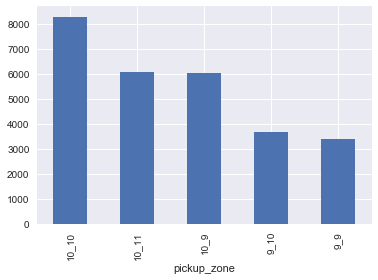

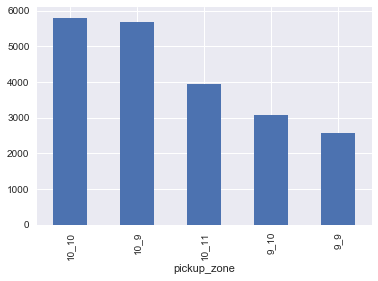

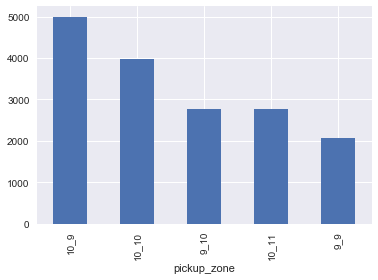

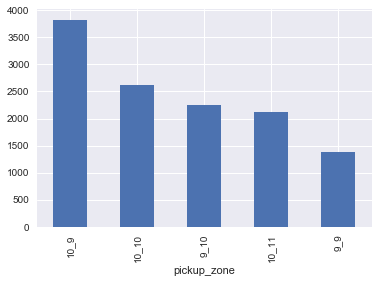

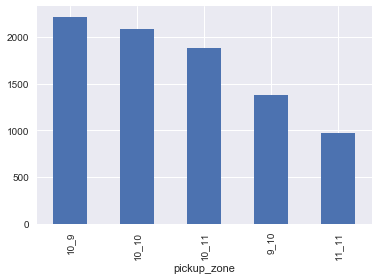

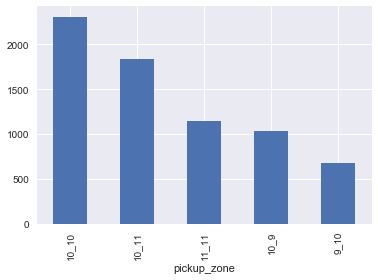

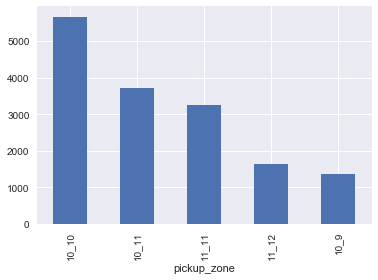

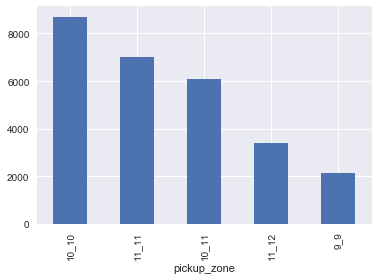

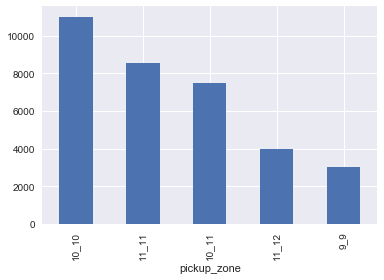

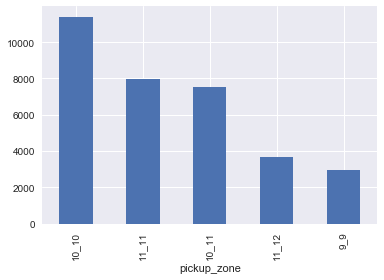

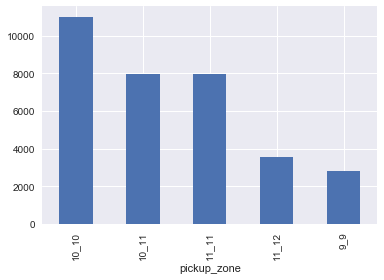

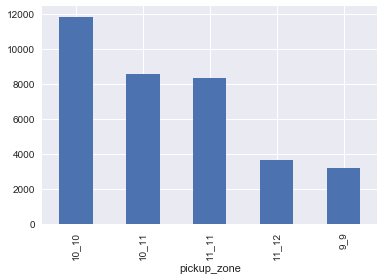

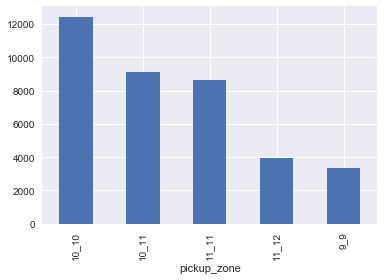

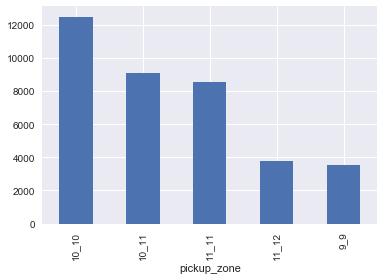

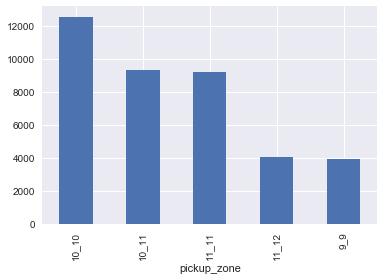

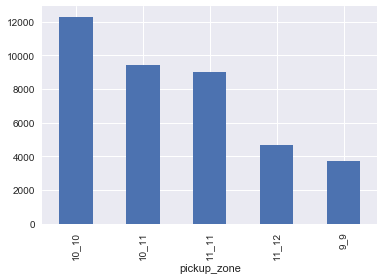

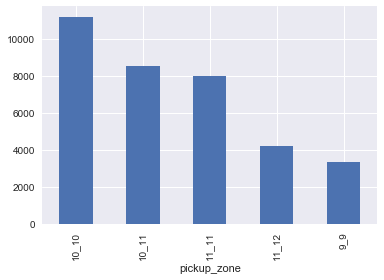

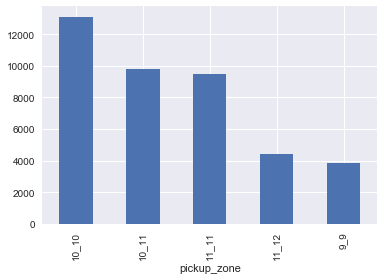

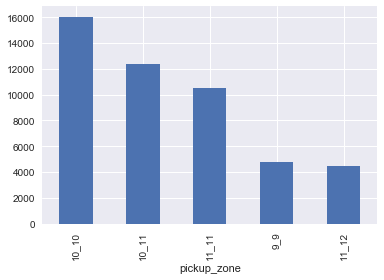

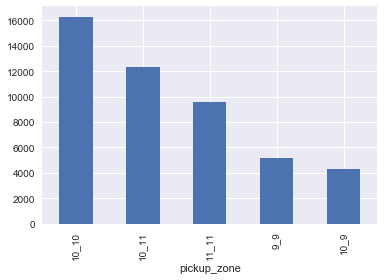

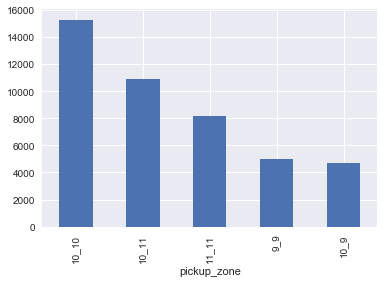

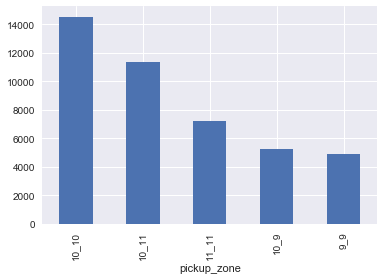

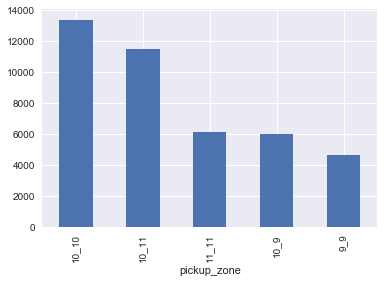

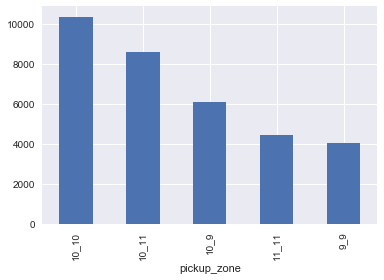

In [35]:
grouped = df.groupby(['pickup_hour', 'pickup_zone']).count()['VendorID']
for hour in range(24):
    grouped[hour].sort_values(ascending=False)[:5].plot(kind='bar')
    plt.show()

<h2>Groupby analysis 2</h2>
<li>Group data by the weekday and the pickup zone
<li>Draw a figure of 7 plots that show the top 5 pickup zones on each day

In [36]:
df['day_of_week'].value_counts()

5    194093
6    161504
7    152614
4    151541
3    145581
2    140295
1    126132
Name: day_of_week, dtype: int64

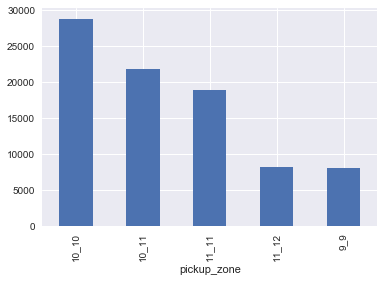

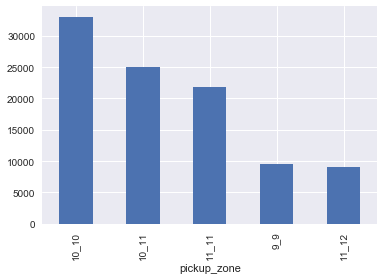

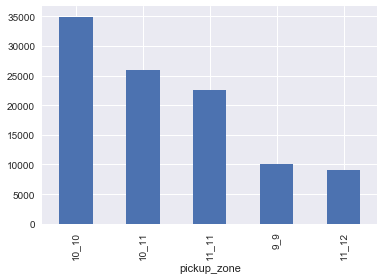

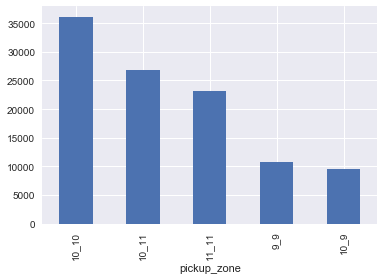

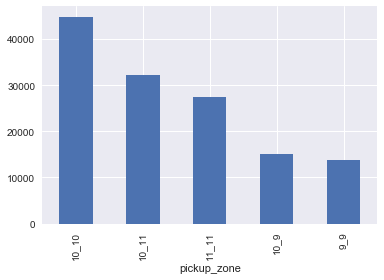

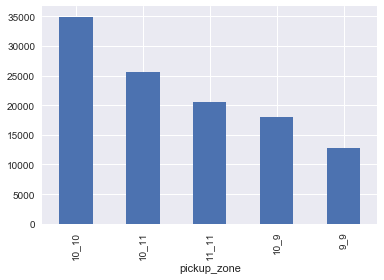

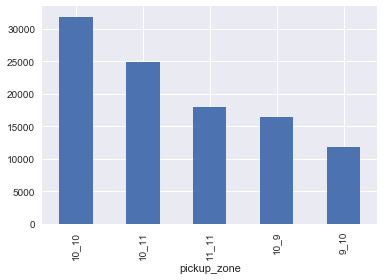

In [37]:
grouped = df.groupby(['day_of_week' , 'pickup_zone']).count()['VendorID']
for day in range(1,8):
    grouped[day].sort_values(ascending=False)[:5].plot(kind='bar')
    plt.show()
    

<h1>Most frequent morning pickups</h1>
<li>Identify the most frequent pickup zone between 8 am and 9 am on a weekday



In [40]:
df[df['pickup_hour'].between(8,9) & df['day_of_week'].between(1,5)]['pickup_zone'].value_counts().index[0]

'10_10'

<h2>Mapping</h2>
<li>Draw a folium map using the polygon geojson object and the counts dataframe (see class example)

In [41]:
import folium

In [66]:
pickups_per_zone = df.groupby(['pickup_zone']).count()['VendorID']
pz = pd.DataFrame(pickups_per_zone)
#pz['zone'] = pd.Series(pz.index)
pz = pz.reset_index(drop=False)
pz.columns = ['zone', 'count']
pz = pz.sort_values(by='count', ascending=False)
pz.head()

,zone,count
6,10_10,244707
7,10_11,182270
23,11_11,152525
21,10_9,83139
225,9_9,76225


In [42]:
m = folium.Map(location = [40.7589, -73.9851], zoom_start=10)

In [68]:
#createGeoJsonObject(zone_table)

In [69]:
m.choropleth(geo_data=createGeoJsonObject(zone_table), data=pz,
            columns=['zone','count'],
            key_on='feature.properties.name',
            fill_color='RdYlGn', fill_opacity=0.3, line_opacity=0.3,
            legend_name='Pickups per Zone')
folium.LayerControl().add_to(m)
m

/Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
'''
And there you have it!
'''